In [1]:
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import numpy as np
import string
from gensim import corpora
import gensim
from nltk.corpus import words
from gensim.models import LdaModel, LsiModel, Word2Vec, CoherenceModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
from collections import defaultdict
from spacy.lang.en import STOP_WORDS
from pprint import pprint

In [2]:
# Topic coherence and its graph, top topics

In [2]:
# configure number of worker for multicore
import multiprocessing
cpu_count = multiprocessing.cpu_count()
worker = cpu_count - 1
print "No of worker to be used = %s"%worker

No of worker to be used = 7


In [3]:
# stop words
stop_wrd = []
with open('stopword.txt') as f:
    for c in f:
        c = c.replace(",","").replace("\n","").replace('"',"").strip()
        stop_wrd.append(c)
stop = list(STOP_WORDS)
print(len(stop))

305


# Creating Functions

In [4]:
# read document using filename
def read_document(file_name):
    print "Reading Document %s"%file_name
    temp = []
    with open(file_name) as f:
        for l in f:
            temp.append(l)
    print "Document Finished Reading"
    temp = clean_document(temp)
    return temp

In [5]:
def clean_document(doc_complete):
    print "Document Cleaning Started"
    doc_clean = []
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    def clean(doc):
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        stop_free = " ".join([i for i in punc_free.split() if i not in stop_wrd])
        stop_free = ' '.join(i for i in stop_free.split() if not i.startswith('u0'))
        stop_free = " ".join([i for i in stop_free.lower().split() if not unicode(i, 'utf-8').isnumeric()])
        normalized = " ".join(lemma.lemmatize(word) for word in stop_free.split())
        return normalized
    doc_clean = [clean(doc).split() for doc in doc_complete]
    print "Document Cleaning Ended"
    return doc_clean

In [6]:
# return token frequency , clean document (using frequency of token)
def frequency_calculate(doc_clean):
    frequency = defaultdict(int)
    for text in doc_clean:
        for token in text:
            frequency[token] += 1        
    # make new text data by removing out the token that have occurence less then 2
    minimum_freq = 1
    len_of_token = 2
    # doc_clean = [[token for token in text if frequency[token] > minimum_freq]
    #           for text in doc_clean]
    doc_clean = [[token for token in text if len(token) > len_of_token and frequency[token] > minimum_freq]
              for text in doc_clean]
    
    return frequency, doc_clean

# LDA (Latent Dirichlet Allocation) Model -- Based on Probabilistic Graphical Models 

<div class="alert alert-block alert-info"> <font color='Blue'> Interpreting pyLDAvis output:
<ul> <li>Bubbles on the left-hand side of plot represents a topic. Larger the bubble, the more prevalent is that topic. </li>
<li>Good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. </li>
<li>Model with too many topics, will have many overlaps, small sized bubbles are clustered in one region of the chart.</li>
<li>The words on the right-hand side are the salient keywords that form the selected topic.</li>
<li>The red bars represent the frequency of a term in a given topic, and the blue bars represent term's frequency across the entire corpus.</li> </ul></font> </div>

In [7]:
def prepare_lda_prerequisite(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary, doc_term_matrix

In [8]:
def run_lda(dictionary,doc_term_matrix,num_topics=100):
    Lda = gensim.models.ldamulticore.LdaMulticore
    ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=20, workers=worker)
    return ldamodel

In [9]:
def make_pyLDAvis(model,doc_term_matrix,dictionary):
    pyLDAvis.enable_notebook()
    py = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

# LSI Model - (Latent Semantic Analysis) 

<div class="alert alert-block alert-info"><font color = 'blue'>Learns latent topics by performing matrix decomposition (SVD) on the term-document matrix
LSI finds low-dimension representation of documents and words.
Faster to train than LDA, but has lower accuracy. </font> </div>

In [10]:
def run_lsi(doc_term_matrix,dictionary,num_topics=100):
    model = LsiModel(doc_term_matrix, id2word=dictionary,num_topics=num_topics)  # train model
    return model

In [11]:
def print_lsi(model,num_topics=200):
    for c in model.print_topics(num_topics):
        print c

# Heat map 
<div class="alert alert-block alert-info"><font color = 'blue'> Strength of color bar represents normalized ratio of how often a topic X is mentioned in Document Y </font> </div>

In [12]:
def heat_map(model):
    K = model.num_topics
    columns = []
    columns_dict = {}
    for k in range(1,K+1):
        columns.append(str(k))
        columns_dict[k-1] = ""
    df = pd.DataFrame(columns = columns)
    pd.set_option('display.width', 1000)
    zz = np.zeros(shape=(1000,K))
    last_number=0
    DC={}
    for x in range (10):
      data = pd.DataFrame(columns_dict,index=[0])
      df=df.append(data,ignore_index=True)  
    for line in model.print_topics(num_topics=K):
        tp, w = line
        #print tp
        probs=w.split("+")
        y=0
        for pr in probs:
            a=pr.split("*")
            df.iloc[y,tp] = a[1]       
            if a[1] in DC:
               zz[DC[a[1]]][tp]=a[0]
            else:
               zz[last_number][tp]=a[0]
               DC[a[1]]=last_number
               last_number=last_number+1
            y=y+1
    
    zz=np.resize(zz,(len(DC.keys()),zz.shape[1]))
    plt.figure(figsize = (8,14))
    plt.pcolor(zz,norm=None, cmap='Blues')
    plt.colorbar(cmap='Blues')
    plt.imshow(zz, cmap='Blues', interpolation='nearest',aspect='auto')
    for val, key in enumerate(DC.keys()):
            plt.text(-2.5, val + 0.5, key,
                     horizontalalignment='left',
                     verticalalignment='top'
                     )
    plt.gca().invert_yaxis()      # flip the y-axis so the texts are in the order
    plt.tight_layout()            # fixes margins
    plt.show()

# PCA (Principal Component Analysis) 

<div class="alert alert-block alert-info"><font color = 'blue'> Statistical procedure to convert a set of observations of correlated variables into set of values of linearly uncorrelated variables called principal componets. </font> </div> 

In [13]:
def pca_scatter_graph(doc_clean):
    sentences = doc_clean
    model = Word2Vec(sentences,workers=3)
    X = model[model.wv.vocab]
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    plt.figure(figsize = (20,20))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    words = list(model.wv.vocab)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.show()

# <div class="alert alert-block alert-info"> <font color='red'> Non-Anonymous User (Neutral Comments) <font> </div> #



In [14]:
# read the document
doc_cleaned = read_document('null_neutralcomment.txt')

Reading Document null_neutralcomment.txt
Document Finished Reading
Document Cleaning Started
Document Cleaning Ended


In [16]:
# frequency_doc = frequency_calculate(doc_cleaned)

In [17]:
dictionary, doc_term_matrix = prepare_lda_prerequisite(doc_cleaned)
ldamodel = run_lda(dictionary,doc_term_matrix)

/home/ubuntu/.virtualenvs/psu/local/lib/python2.7/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [18]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

/home/ubuntu/.virtualenvs/psu/local/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
89     13.311188        1       1  0.402041  0.120892
62      2.888454        1       2  0.225282  0.102383
72      2.654244        1       3  0.189342  0.050611
61      1.911140        1       4  0.142615  0.056394
26      1.598677        1       5  0.055628  0.011599
74      1.592171        1       6  0.064592  0.026433
2       1.507581        1       7  0.073416  0.017157
21      1.380756        1       8  0.088435  0.054712
45      1.336750        1       9  0.035080  0.049324
48      1.334229        1      10  0.043511  0.067694
53      1.333480        1      11  0.147376 -0.280507
32      1.237827        1      12  0.138222 -0.257745
4       1.204899        1      13  0.032933  0.011413
57      1.183194        1      14  0.035554  0.052176
18      1.158378        1      15  0.163696 -0.302011
10      1.134969        1      16  0.033965  0.015682
28      1.119969        1      17  0.018038 -0.003189
49      1.118532        1      18  0.085281  0.047750
29      1.105520        1      19  0.024274  0.042156
51      1.103919        1      20  0.024072  0.041727
70      1.067176        1      21  0.026944  0.047234
73      1.040501        1      22  0.040809  0.025170
60      1.029798        1      23 -0.010380  0.004437
84      1.029572        1      24  0.003413 -0.015284
80      0.985643        1      25  0.043374  0.038424
19      0.970922        1      26 -0.004537 -0.014322
58      0.969784        1      27  0.003470  0.035921
77      0.965928        1      28  0.001748 -0.033167
93      0.946406        1      29 -0.033163  0.008601
81      0.937537        1      30  0.006576  0.009905
...          ...      ...     ...       ...       ...
11      0.663054        1      71 -0.039464 -0.000189
47      0.655288        1      72 -0.040072  0.001656
94      0.650549        1      73 -0.027392  0.008728
50      0.639327        1      74 -0.029644 -0.006155
23      0.638234        1      75 -0.044712  0.002041
39      0.638184        1      76 -0.022325  0.021720
56      0.637816        1      77 -0.053849 -0.004497
95      0.631659        1      78 -0.047369 -0.022876
5       0.625296        1      79 -0.007341 -0.008746
54      0.608569        1      80 -0.054406 -0.003192
35      0.599086        1      81 -0.033219  0.002092
79      0.598172        1      82 -0.063139 -0.002780
82      0.596275        1      83  0.023151  0.044335
68      0.595214        1      84 -0.052137  0.002848
7       0.591700        1      85 -0.048122 -0.024845
0       0.589936        1      86 -0.044305 -0.002886
59      0.574658        1      87 -0.052780 -0.000833
90      0.561622        1      88 -0.036667  0.015984
27      0.549800        1      89 -0.045140 -0.018658
96      0.547510        1      90  0.014691 -0.118622
69      0.540386        1      91 -0.035273 -0.002028
31      0.509846        1      92 -0.051575 -0.016933
99      0.474010        1      93 -0.067958 -0.012860
55      0.469023        1      94 -0.046647 -0.016451
41      0.465574        1      95 -0.061703 -0.022589
9       0.456392        1      96 -0.061729 -0.021422
24      0.448211        1      97 -0.065254 -0.012554
42      0.426291        1      98 -0.062013 -0.009163
71      0.405001        1      99 -0.066808 -0.004361
87      0.290536        1     100 -0.085058 -0.013433

[100 rows x 5 columns], topic_info=      Category        Freq                                               Term  \
term                                                                            
4554   Default  213.000000                                            comment   
1583   Default  381.000000                                             police   
3004   Default  361.000000                                            figarez   
3704   Default  361.000000                                         registered   
3586   Default  364.000000                   

In [19]:
lsimodel = run_lsi(doc_term_matrix,dictionary,20)
print_lsi(lsimodel)

(0, u'0.380*"police" + 0.380*"day" + 0.379*"case" + 0.377*"hiding" + 0.377*"back" + 0.376*"registered" + 0.376*"figarez" + 0.004*"court" + 0.002*"order" + 0.002*"woman"')
(1, u'0.335*"r" + 0.271*"sab" + 0.261*"salman" + 0.260*"harami" + 0.260*"kali" + 0.259*"garam" + 0.259*"pyali" + 0.259*"biwi" + 0.259*"modiek" + 0.259*"wali"')
(2, u'-0.426*"calling" + -0.406*"whatsapp" + -0.406*"feature" + -0.405*"user" + -0.404*"version" + -0.402*"update" + -0.008*"name" + -0.006*"party" + -0.005*"wifi" + -0.003*"window"')
(3, u'0.847*"comment" + 0.369*"email" + 0.159*"add" + 0.159*"address" + 0.158*"notification" + 0.158*"subscribe" + 0.146*"awaiting" + 0.146*"moderation" + 0.030*"deleted" + 0.018*"party"')
(4, u'-0.424*"people" + -0.414*"party" + -0.323*"dhoka" + -0.269*"member" + -0.267*"delhi" + -0.230*"gang" + -0.214*"bangladesh" + -0.212*"reportedly" + -0.211*"underground" + -0.210*"slipped"')
(5, u'0.378*"member" + 0.335*"gang" + 0.331*"bangladesh" + 0.327*"underground" + 0.326*"reportedly" +

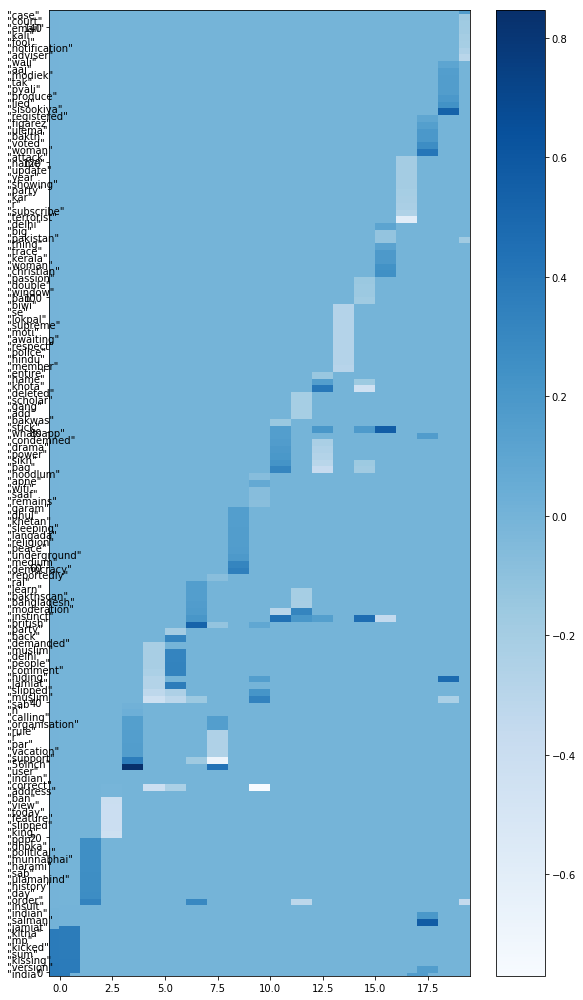

In [20]:
heat_map(lsimodel)

/home/ubuntu/.virtualenvs/psu/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


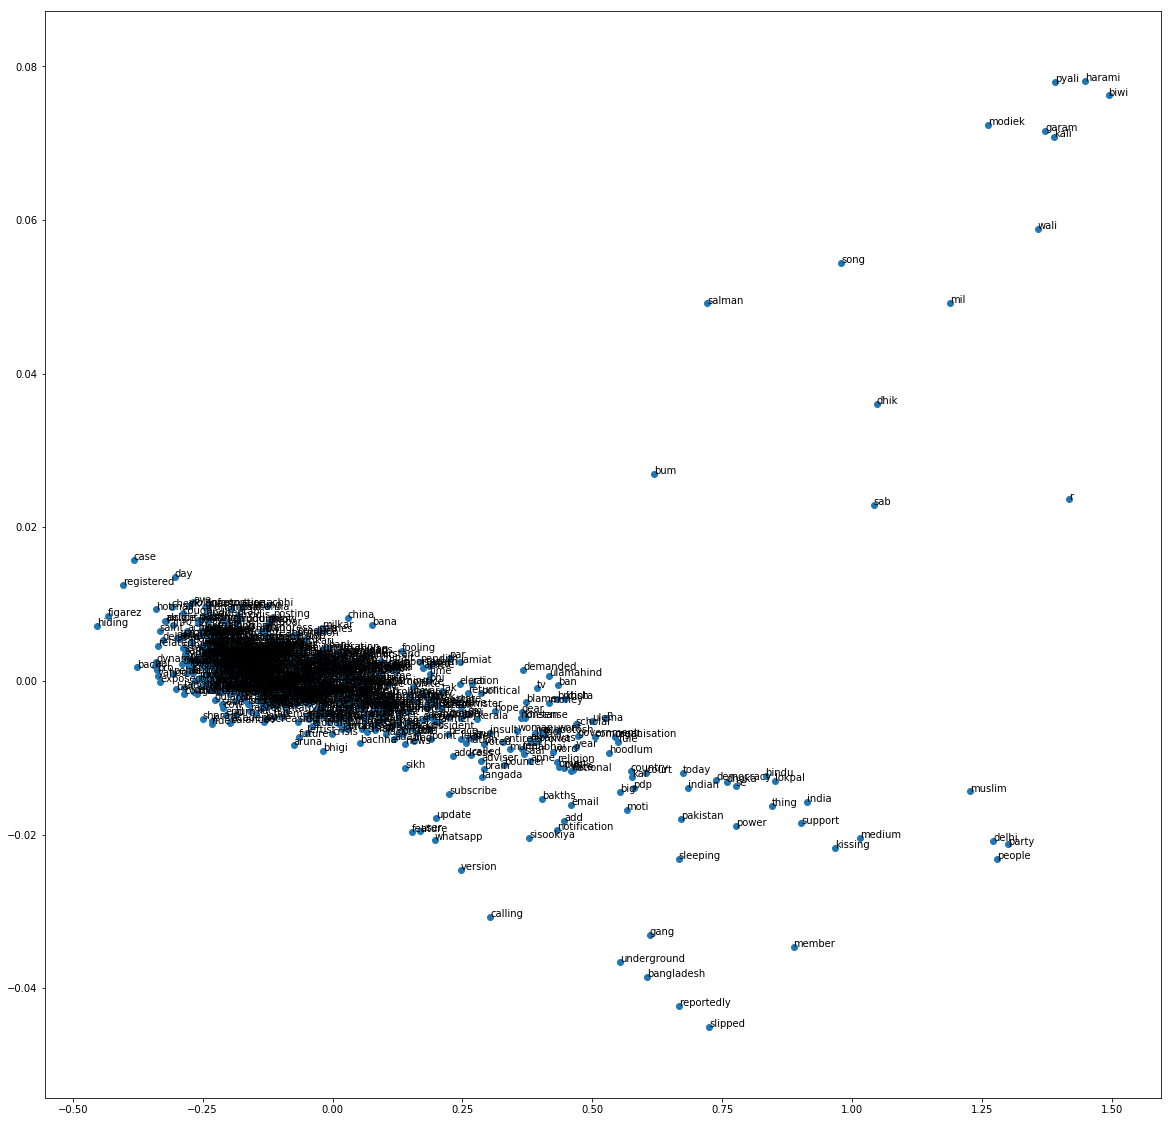

In [21]:
pca_scatter_graph(doc_cleaned)

# <div class="alert alert-block alert-info"><font color='red'> Anonymous user (Neutral Comments) </font></div>

In [26]:
# read the document
doc_cleaned = read_document('anony_neutralcomment.txt')

Reading Document anony_neutralcomment.txt
Document Finished Reading
Document Cleaning Started
Document Cleaning Ended


In [27]:
frequency_doc = frequency_calculate(doc_cleaned)

In [32]:
dictionary, doc_term_matrix = prepare_lda_prerequisite(doc_cleaned)
ldamodel = run_lda(dictionary,doc_term_matrix,20)

In [33]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

/home/ubuntu/.virtualenvs/psu/local/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
16     17.446594        1       1 -0.341259 -0.011843
4       7.879811        1       2 -0.000409  0.134294
14      7.381576        1       3  0.062643  0.150781
15      7.244817        1       4  0.013420  0.037389
6       6.956545        1       5  0.055467 -0.155369
17      6.896857        1       6  0.049341 -0.148378
2       6.337803        1       7 -0.051992 -0.024666
11      5.322019        1       8  0.031373  0.009099
5       5.203955        1       9  0.045835 -0.005584
19      4.389974        1      10  0.001862 -0.008488
18      4.204789        1      11  0.026649 -0.006816
0       3.686657        1      12  0.021892  0.030183
10      3.564182        1      13  0.017728 -0.002364
8       3.510516        1      14  0.029518  0.007748
1       2.498329        1      15  0.015038  0.002241
9       2.417979        1      16 -0.004573 -0.004405
7       1.993278        1      17  0.013839  0.002267
12      1.235702        1      18  0.009193  0.000768
13      1.097962        1      19  0.005835 -0.008086
3       0.730652        1      20 -0.001400  0.001229, topic_info=     Category      Freq           Term     Total  loglift  logprob
term                                                              
243   Default  5.000000          daily  5.000000  30.0000  30.0000
193   Default  3.000000          india  3.000000  29.0000  29.0000
5     Default  4.000000           govt  4.000000  28.0000  28.0000
21    Default  1.000000          tring  1.000000  27.0000  27.0000
118   Default  1.000000          agree  1.000000  26.0000  26.0000
168   Default  1.000000        usurped  1.000000  25.0000  25.0000
109   Default  1.000000           bury  1.000000  24.0000  24.0000
224   Default  1.000000         farmer  1.000000  23.0000  23.0000
154   Default  1.000000         friend  1.000000  22.0000  22.0000
22    Default  1.000000        zillion  1.000000  21.0000  21.0000
238   Default  1.000000           land  1.000000  20.0000  20.0000
210   Default  1.000000         belong  1.000000  19.0000  19.0000
180   Default  2.000000           work  2.000000  18.0000  18.0000
64    Default  1.000000      mandatory  1.000000  17.0000  17.0000
101   Default  1.000000     government  1.000000  16.0000  16.0000
130   Default  1.000000           feel  1.000000  15.0000  15.0000
206   Default  2.000000            cji  2.000000  14.0000  14.0000
173   Default  1.000000          obama  1.000000  13.0000  13.0000
95    Default  1.000000   hypocritical  1.000000  12.0000  12.0000
227   Default  1.000000           hang  1.000000  11.0000  11.0000
17    Default  1.000000        culprit  1.000000  10.0000  10.0000
96    Default  1.000000         proper  1.000000   9.0000   9.0000
230   Default  1.000000            day  1.000000   8.0000   8.0000
115   Default  2.000000        invited  2.000000   7.0000   7.0000
39    Default  1.000000          world  1.000000   6.0000   6.0000
13    Default  2.000000          style  2.000000   5.0000   5.0000
246   Default  1.000000           time  1.000000   4.0000   4.0000
32    Default  3.000000            big  3.000000   3.0000   3.0000
44    Default  3.000000          stuff  3.000000   2.0000   2.0000
172   Default  3.000000         buying  3.000000   1.0000   1.0000
...       ...       ...            ...       ...      ...      ...
152   Topic20  0.010567            lot  1.066463   0.3046  -5.5255
134   Topic20  0.010567           duck  1.066463   0.3046  -5.5255
78    Topic20  0.010567         closet  1.830848  -0.2358  -5.5255
91    Topic20  0.010567             mp  1.196766   0.1893  -5.5255
90    Topic20  0.010567        whipped  1.178926   0.2043  -5.5255
89    Topic20  0.010567     corruption  2.440855  -0.5234  -5.5255
88    Topic20  0.010567         bharat  1.125325   0.2509  -5.5255
87    Topic20  0.010567        routine  1.161592   0.2192  -5.5255
86    Topic20  0.01056

In [34]:
lsimodel = run_lsi(doc_term_matrix,dictionary,20)
print_lsi(lsimodel)

(0, u'0.378*"daily" + 0.326*"basis" + 0.326*"sell" + 0.326*"sane" + 0.326*"person" + 0.326*"dealsaid" + 0.326*"buying" + 0.326*"stuff" + 0.326*"big" + 0.029*"india"')
(1, u'-0.455*"govt" + -0.265*"point" + -0.246*"supposed" + -0.246*"selling" + -0.246*"popularity" + -0.246*"judge" + -0.246*"photo" + -0.246*"aloof" + -0.246*"butpoliticians" + -0.246*"ad"')
(2, u'0.380*"cji" + 0.315*"system" + 0.315*"incompetentcorrupt" + 0.315*"caught" + 0.315*"increasingly" + 0.315*"judicial" + 0.315*"litigant" + 0.315*"royally" + 0.315*"screed" + 0.095*"invited"')
(3, u'0.300*"govt" + 0.238*"party" + 0.230*"crore" + 0.203*"maha" + 0.203*"supported" + 0.203*"colour" + 0.203*"forming" + 0.203*"joined" + 0.203*"thing" + 0.203*"offerred"')
(4, u'0.432*"invited" + 0.336*"corruption" + 0.310*"oscar" + 0.310*"awardsbtw" + 0.310*"expose" + 0.310*"mafia" + 0.310*"sting" + 0.132*"mandatory" + 0.122*"abstained" + 0.122*"conference"')
(5, u'0.302*"world" + 0.275*"savagery" + 0.275*"karma" + 0.275*"justice" + 0.27

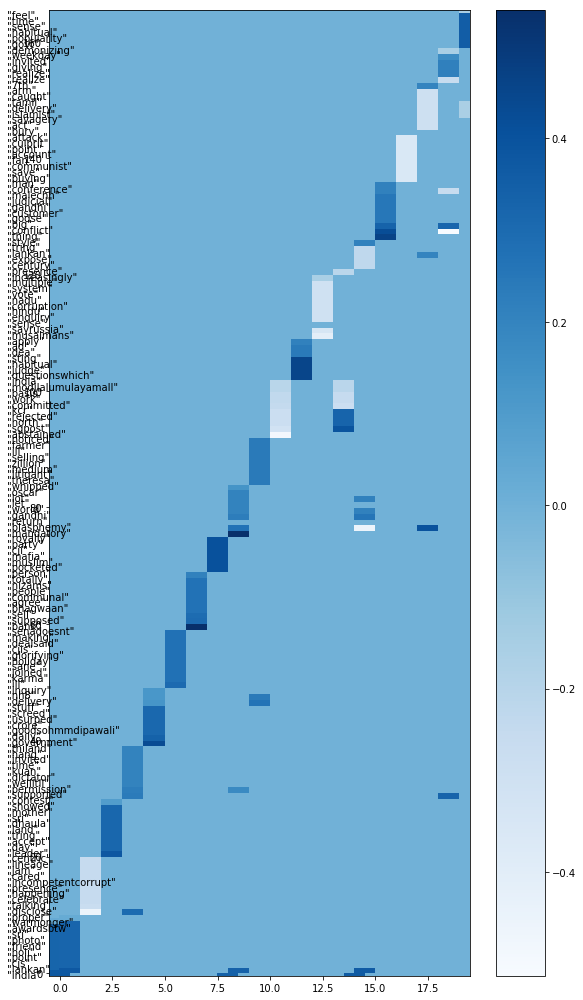

In [59]:
heat_map(lsimodel)

/home/ubuntu/.virtualenvs/psu/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


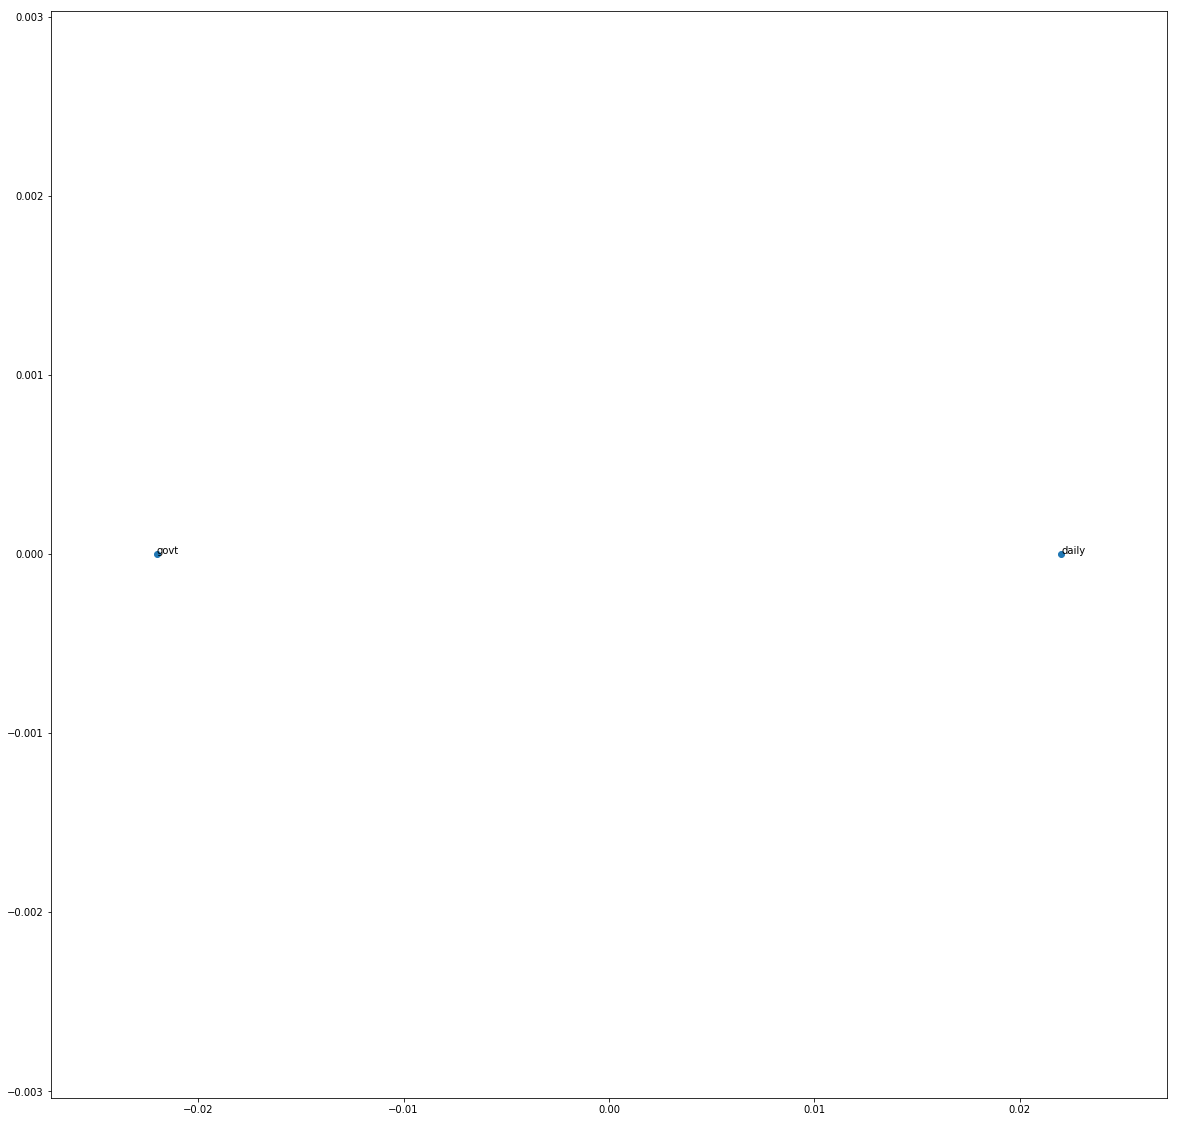

In [60]:
pca_scatter_graph(doc_cleaned)

# <div class="alert alert-block alert-info"> <font color='red'> Users with Anonymous profiles (Neutral Comments) </font> </div>

In [75]:
# read the document
doc_cleaned = read_document('null_neutralcomment.txt')

Reading Document null_neutralcomment.txt
Document Finished Reading
Document Cleaning Started
Document Cleaning Ended


In [76]:
frequency_doc = frequency_calculate(doc_cleaned)

In [77]:
dictionary, doc_term_matrix = prepare_lda_prerequisite(doc_cleaned)
ldamodel = run_lda(dictionary,doc_term_matrix)

In [78]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

/home/ubuntu/.virtualenvs/psu/local/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
81     13.259495        1       1 -0.391655  0.114208
70      2.892957        1       2 -0.217428 -0.006730
11      2.866732        1       3 -0.224688 -0.134123
67      2.854811        1       4 -0.218305  0.054841
43      1.840546        1       5 -0.125553 -0.144786
9       1.767550        1       6 -0.104425  0.046094
14      1.505556        1       7 -0.180018 -0.021909
28      1.485736        1       8 -0.051777 -0.114244
95      1.469216        1       9 -0.084777 -0.046809
4       1.431892        1      10 -0.099980  0.094895
35      1.395652        1      11 -0.030208  0.032464
86      1.388100        1      12 -0.048894  0.053974
23      1.311648        1      13 -0.039164 -0.141662
34      1.176140        1      14 -0.038436  0.101928
26      1.163240        1      15 -0.039867 -0.007875
97      1.157381        1      16 -0.027580  0.011337
25      1.102042        1      17 -0.019571 -0.103602
29      1.034068        1      18  0.001240 -0.002284
73      1.033921        1      19 -0.019521  0.053792
59      1.030528        1      20  0.012145  0.060402
69      1.003443        1      21 -0.018330  0.080706
63      0.976738        1      22 -0.012674  0.006476
51      0.954544        1      23  0.010799 -0.078729
92      0.952392        1      24 -0.004790  0.011300
99      0.951846        1      25 -0.008350  0.000528
94      0.948119        1      26 -0.009276 -0.101221
17      0.938873        1      27 -0.023915  0.048882
22      0.936015        1      28  0.000404  0.045920
2       0.917433        1      29  0.016371  0.033909
0       0.915999        1      30  0.009225 -0.010184
...          ...      ...     ...       ...       ...
33      0.673674        1      71  0.047131  0.041741
88      0.671059        1      72  0.018435 -0.015955
20      0.665642        1      73  0.017941  0.049198
91      0.662043        1      74  0.041016  0.036470
38      0.660084        1      75  0.033611  0.024964
36      0.638768        1      76  0.042702  0.004523
40      0.638450        1      77  0.045057  0.002693
24      0.608178        1      78  0.044163  0.033150
46      0.589202        1      79  0.061280  0.030371
64      0.588764        1      80  0.049854  0.012923
30      0.587749        1      81  0.052710  0.029539
41      0.586066        1      82  0.041824 -0.028097
3       0.583368        1      83  0.042181  0.039642
65      0.564380        1      84  0.045054  0.031662
16      0.562460        1      85  0.037506  0.035763
96      0.558976        1      86  0.030810  0.016314
10      0.557040        1      87  0.050909  0.016505
53      0.544914        1      88  0.038976 -0.077421
87      0.536804        1      89  0.050227  0.020311
77      0.536484        1      90  0.071330  0.029863
21      0.527072        1      91  0.044818 -0.042972
37      0.500039        1      92  0.072473  0.022759
54      0.494262        1      93  0.035014 -0.052327
58      0.487894        1      94  0.070244  0.043894
32      0.465955        1      95  0.052166 -0.051395
55      0.415172        1      96  0.070588 -0.015524
75      0.408789        1      97  0.052924  0.026837
82      0.404898        1      98  0.053124 -0.072596
83      0.390169        1      99  0.067945 -0.026180
71      0.295572        1     100  0.093808  0.022980

[100 rows x 5 columns], topic_info=      Category        Freq            Term       Total  loglift  logprob
term                                                                    
4554   Default  211.000000         comment  211.000000  30.0000  30.0000
1583   Default  382.000000          police  382.000000  29.0000  29.0000
3704   Default  362.000000      registered  362.000000  28.0000  28.0000
3004   Default  362.000000         figarez  362.000000  27.0000  27.0000
4160   Default  382.000000             day  382.000000  26.0000  26.0000
3586   Default  365.

In [79]:
lsimodel = run_lsi(doc_term_matrix,dictionary,20)
print_lsi(lsimodel)

(0, u'-0.380*"police" + -0.380*"day" + -0.379*"case" + -0.377*"hiding" + -0.377*"back" + -0.376*"registered" + -0.376*"figarez" + -0.004*"court" + -0.002*"order" + -0.002*"woman"')
(1, u'-0.335*"r" + -0.271*"sab" + -0.261*"salman" + -0.260*"harami" + -0.260*"kali" + -0.259*"modiek" + -0.259*"wali" + -0.259*"song" + -0.259*"garam" + -0.259*"dhik"')
(2, u'-0.426*"calling" + -0.406*"whatsapp" + -0.406*"feature" + -0.405*"user" + -0.404*"version" + -0.402*"update" + -0.008*"name" + -0.006*"party" + -0.005*"wifi" + -0.003*"window"')
(3, u'-0.847*"comment" + -0.369*"email" + -0.159*"add" + -0.159*"address" + -0.158*"notification" + -0.158*"subscribe" + -0.145*"moderation" + -0.145*"awaiting" + -0.030*"deleted" + -0.018*"party"')
(4, u'0.424*"people" + 0.414*"party" + 0.323*"dhoka" + 0.269*"member" + 0.267*"delhi" + 0.230*"gang" + 0.214*"bangladesh" + 0.212*"reportedly" + 0.211*"underground" + 0.210*"slipped"')
(5, u'0.378*"member" + 0.335*"gang" + 0.331*"bangladesh" + 0.327*"underground" + 0

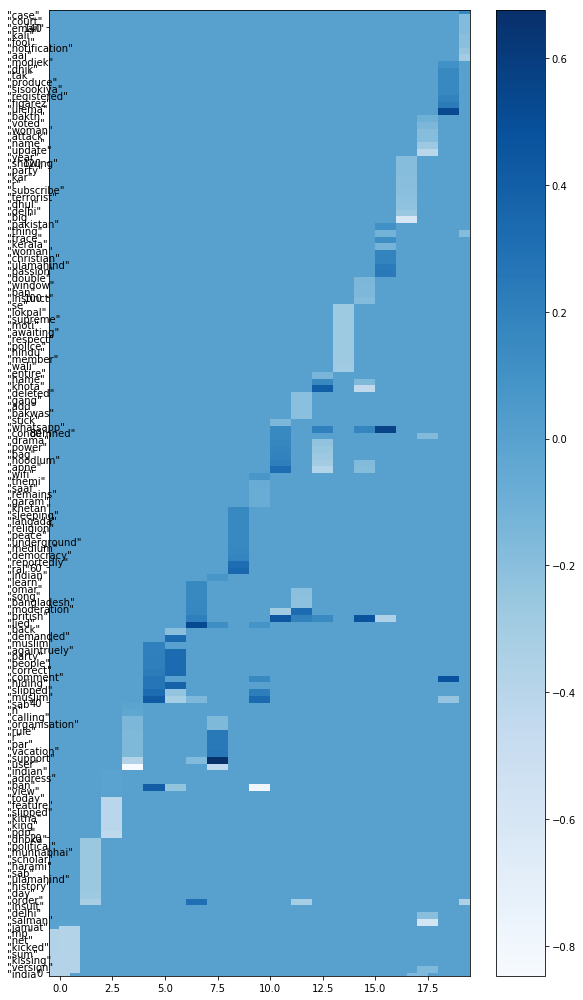

In [80]:
heat_map(lsimodel)

/home/ubuntu/.virtualenvs/psu/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


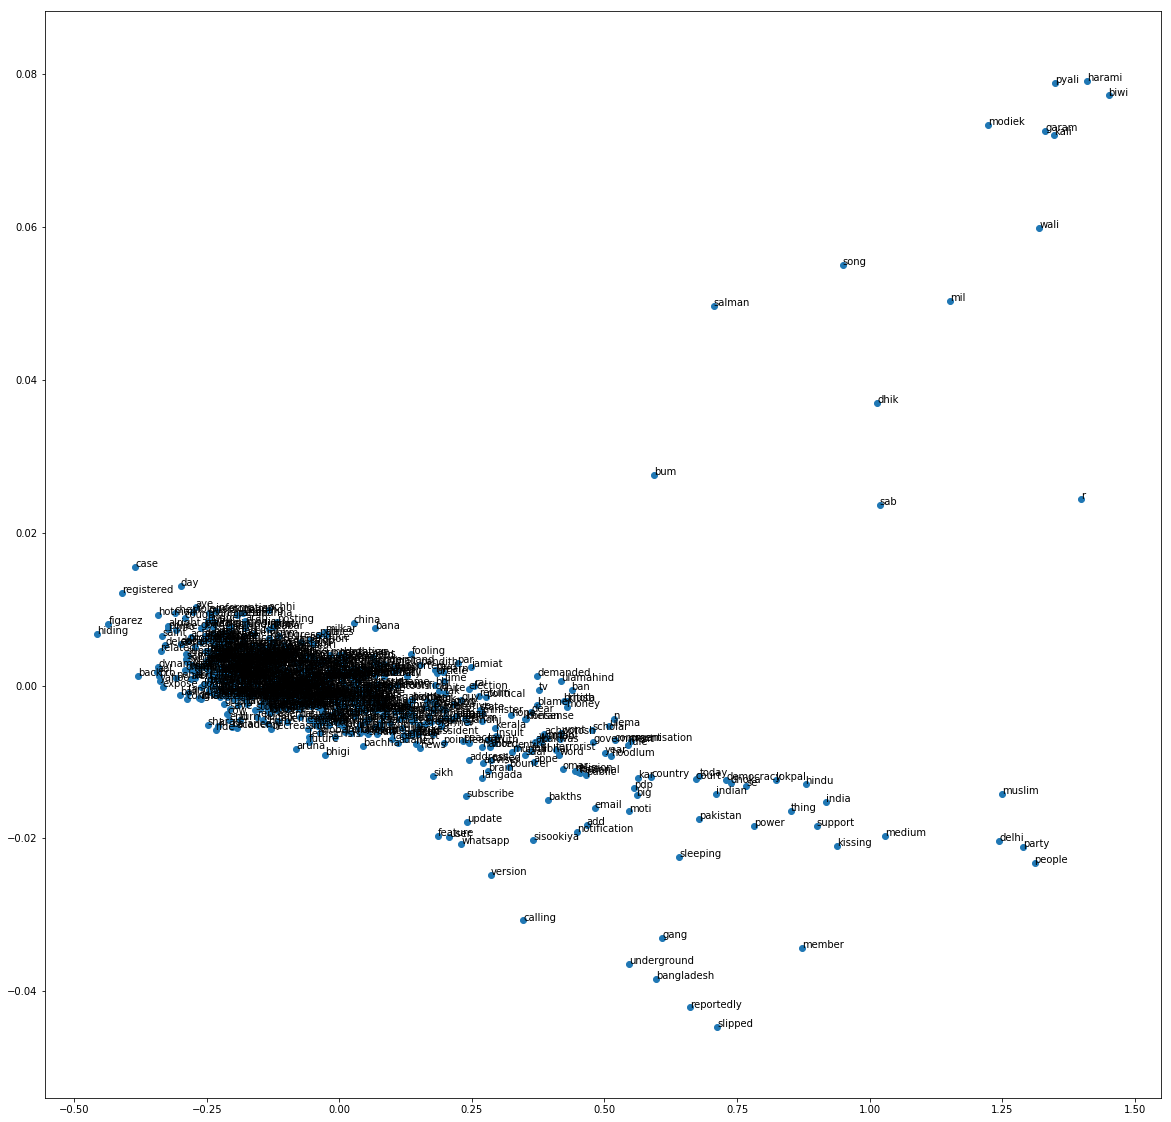

In [81]:
pca_scatter_graph(doc_cleaned)